In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from dask import dataframe as dd
pd.options.mode.chained_assignment = None

## Reading and preparing the data

In [ ]:
transactions = dd.read_csv('data/transactions_train.csv', dtype={'article_id': str})
articles = dd.read_csv('data/articles.csv', dtype={'article_id': str})[["article_id", "section_name"]]
customers = dd.read_csv('data/customers.csv', dtype={'customer_id': str})[["customer_id", "age"]]
submission = pd.read_csv("data/sample_submission.csv")

In [ ]:
transactions = transactions.drop_duplicates(["customer_id", "article_id"])
transactions = transactions[transactions["t_dat"] >= '2019-09-24']
transactions = transactions.drop_duplicates(["article_id", "customer_id"])

In [ ]:
def gender_classification(age):
    if age < 19:
        return 0
    elif age < 29:
        return 1
    elif age < 49:
        return 2
    elif age < 59:
        return 3
    elif age < 69:
        return 4
    else:
        return 5

customers["age-bins"] = customers.age.fillna(np.mean(customers.age))
customers.age = customers.age.map(gender_classification)

In [ ]:
def gender_classification(section_name):
    if "womens" in section_name or "girl" in section_name or "ladies" in section_name:
        return "woman"
    elif "men" in section_name or "boy" in section_name or "boys" in section_name:
        return "man"
    else:
        return "other"

articles.section_name = articles.section_name.map(lambda x: x.lower())
articles["gender_group"] = articles.section_name.apply(gender_classification, meta=("gender", "O"))

In [ ]:
# Run time nearly 2m
transactions = transactions.merge(articles[["article_id", "gender_group"]], on="article_id", how="inner")
transactions = transactions.merge(customers[["customer_id","age"]], on="customer_id", how="inner")
transactions = transactions.compute()
customers = customers.compute()
del articles

In [ ]:
# Run time nearly 2m
customer_hist = transactions.groupby(by="customer_id").agg({"article_id": lambda x: list(x.values), "gender_group": lambda x : x.mode().iloc[0]}).reset_index()
customers = customers.merge(customer_hist, on="customer_id", how="left")
customers.article_id = customers.article_id.fillna("").apply(list)
customers.gender_group = customers.gender_group.fillna("other")
del customer_hist

In [ ]:
transactions = transactions.drop(columns=["age", "gender_group"])
transactions = transactions.merge(customers[["customer_id", "age", "gender_group"]], on="customer_id", how="inner")
transactions["score"] = 1.0
transactions.head()

In [ ]:
transactions.t_dat = pd.to_datetime(transactions.t_dat) - timedelta(2)
transactions["week"] = transactions.t_dat.dt.isocalendar().week
transactions.week = transactions.week.apply(lambda w: (w + 15) % 54)

In [ ]:
weekly_score = transactions.groupby(["article_id", "age", "week"]).agg({"score":"sum"}).reset_index()
lw_score = weekly_score[weekly_score.week == 53][["article_id","score"]]
lw_score.rename(columns = {'score':'last_score'}, inplace=True)

weekly_score = weekly_score.merge(lw_score, on="article_id", how="inner")
weekly_score["quotient"] = weekly_score.last_score/weekly_score.score

In [ ]:
age_score = weekly_score.groupby(['article_id',"age"])['quotient'].sum().reset_index()
age_score = age_score.sort_values(['age', 'quotient'], ascending=False)

## Model

In [ ]:
most_solds_age = transactions[transactions.week.isin([53,52,51])].groupby(["article_id", "age"]).agg({"score":"sum"})\
                                .rename(columns={"score":"demographic_score"}).reset_index()\
                                .sort_values('demographic_score', ascending=False)



most_solds_age_gender = transactions[transactions.week.isin([53,52,51])].groupby(["article_id", "age", "gender_group"]).agg({"score":"sum"})\
                                    .rename(columns={"score":"demographic_score"}).reset_index()\
                                    .sort_values('demographic_score', ascending=False)

## Sample Submission

In [ ]:
most_sold_age_dict = {}
most_solds = most_solds_age
age_group = most_solds.age.unique()

for i in age_group:
    most_sold_50 = most_solds[most_solds.age ==i].article_id.head(50).values
    most_sold_age_dict[f"{i}"] =  most_sold_50

most_sold_age_gender_dict = {}
most_solds = most_solds_age_gender
age_group = most_solds.age.unique()
gender_group = most_solds.gender_group.unique()

for i in age_group:
    for j in gender_group:
        most_sold_50 = most_solds[(most_solds.age ==i) & (most_solds.gender_group ==j)].article_id.head(50).values
        most_sold_age_gender_dict[f"{i}_{j}"] =  most_sold_50

In [ ]:
def model_predict(row):
    if row.age in [1,2,3] and row.gender_group in ['man', 'woman'] and len(row.article_id)>1:
            return most_sold_age_gender_dict[f"{row.age}_{row.gender_group}"]
    else:
        return most_sold_age_dict[f"{row.age}"]

customers["prediction"] = customers.apply(model_predict, axis=1)
customers.prediction = customers.prediction.apply(lambda x: " ".join(x[:12]))
customers[["customer_id", "prediction"]].to_csv("submission.csv", index=False)

In [ ]:
most_solds_age_gender.head()

## Most Sold Analyses

In [ ]:
transactions = dd.read_csv('data/transactions_train.csv')
transactions = transactions[transactions["t_dat"] >= '2020-02-15']
transactions = transactions.drop_duplicates(subset=["customer_id","article_id"])
most_solds = transactions.groupby(["article_id"]).agg({"article_id":"count"})\
                                .rename(columns={"article_id":"_count"}).reset_index()\
                                .sort_values('_count', ascending=False)
most_solds = most_solds.compute()

In [ ]:
intersections = []
total_score =  most_solds._count.sum()
for i in range(50, 10000, 50):
    intersections.append(most_solds.head(i)._count.sum() / total_score)

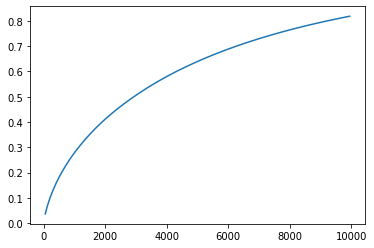

In [184]:
plt.plot(list(range(50, 10000, 50)), intersections)

In [ ]:
plt.savefig()